### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [78]:
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content with data cleaning
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [2]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [161]:
T0 = np.array(data[2], dtype = str)
ra = np.array(data[3], dtype= float)
decl = np.array(data[4], dtype = float)
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9], dtype = float)
redshift = np.array(data[11], dtype = float)
T100 = np.array(data[12], dtype = float)
condition = (T90 != -999) 
T90 = T90[condition]
log10T90 = np.log10(T90)

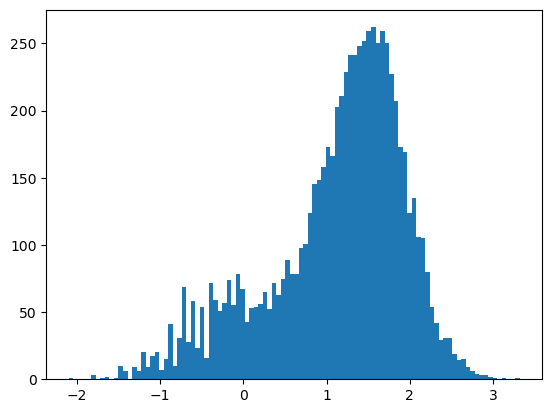

In [4]:
plt.hist(log10T90, bins = 100)
plt.show()

In [11]:
#Execute this cell to determine the bandwidth
bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
K = 2 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(log10T90[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.13692307692307693


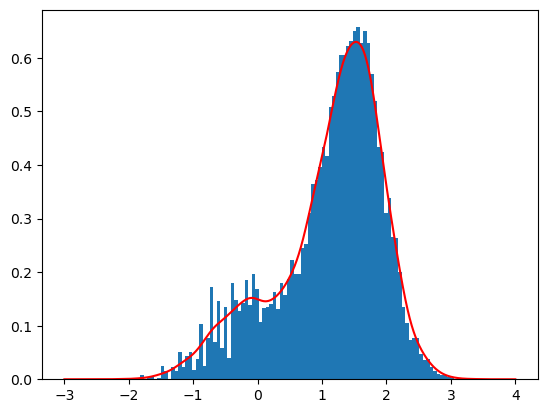

In [109]:
def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

xgrid = np.linspace(-3,4,len(log10T90))
pdf = kde_sklearn(log10T90,bandwidth=h_opt)
plt.plot(xgrid,pdf,c='red')
plt.hist(log10T90, bins = 100, density = True);

In [21]:
clf = KMeans(n_clusters = 2, n_init = 10)
clf.fit(log10T90[:, None])

KMeans(n_clusters=2, n_init=10)

In [22]:
clf.cluster_centers_

array([[ 1.52287078],
       [-0.04011202]])

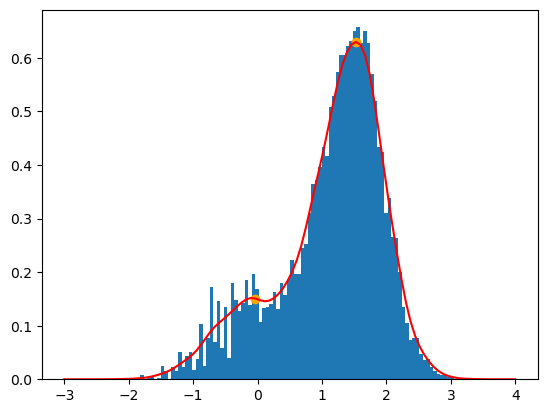

In [23]:
plt.plot(xgrid,pdf,c='red')
counts, edges, bars = plt.hist(log10T90, bins = 100, density = True)
plt.scatter(clf.cluster_centers_[0], pdf[np.argmin(np.abs(clf.cluster_centers_[0]-xgrid))], color = 'orange')
plt.scatter(clf.cluster_centers_[1], pdf[np.argmin(np.abs(clf.cluster_centers_[1]-xgrid))], color = 'orange');

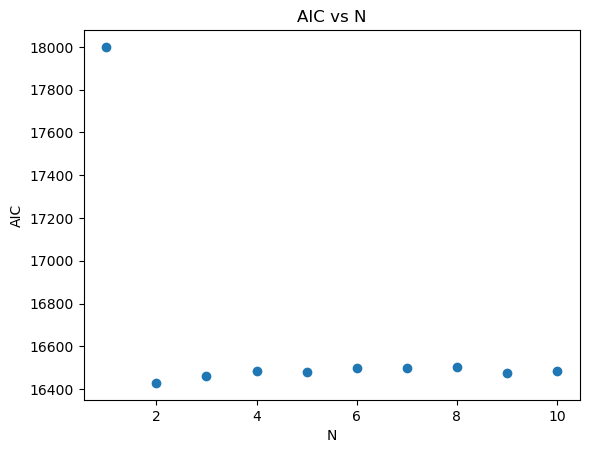

In [27]:
N = [1,2,3,4,5,6,7,8,9,10]
AIC = []
for i in N:
    gm = GaussianMixture(n_components=i, random_state=0).fit(log10T90[:, None])
    #fig = plt.figure()
    #plt.hist(dati, bins = 50, density = True)
    #plt.plot(a, np.exp(gm.score_samples(a[:,np.newaxis])))
    AIC.append(gm.aic(log10T90[:,None]))
    i = i+1

plt.scatter(N, AIC)
plt.xlabel('N')
plt.ylabel('AIC')
plt.title('AIC vs N')
plt.show()

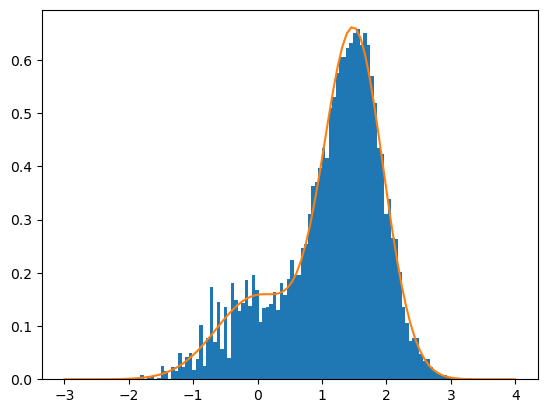

In [33]:
gm = GaussianMixture(n_components=2, random_state=0).fit(log10T90[:, None])
plt.hist(log10T90, bins = 100, density = True)
plt.plot(xgrid, np.exp(gm.score_samples(xgrid[:,np.newaxis])))
#plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$')
#plt.ylabel(r'$p(\theta)$')
plt.show()

In [54]:
print('First cluster center computed with Kmeans, Gaussian Mixture: ', gm.means_[0], clf.cluster_centers_[1])
print('Second cluster center computed with Kmeans, Gaussian Mixture and difference: ', gm.means_[1], clf.cluster_centers_[0])

First cluster center computed with Kmeans, Gaussian Mixture and difference:  [-0.01517555] [-0.04011202]
Second cluster center computed with Kmeans, Gaussian Mixture and difference:  [1.48871716] [1.52287078]


In [57]:
print('First cluster center difference: ',  np.abs(gm.means_[0]-clf.cluster_centers_[1]))
print('Second cluster center difference: ',  np.abs(gm.means_[1]-clf.cluster_centers_[0]))

First cluster center difference:  [0.02493646]
Second cluster center difference:  [0.03415361]


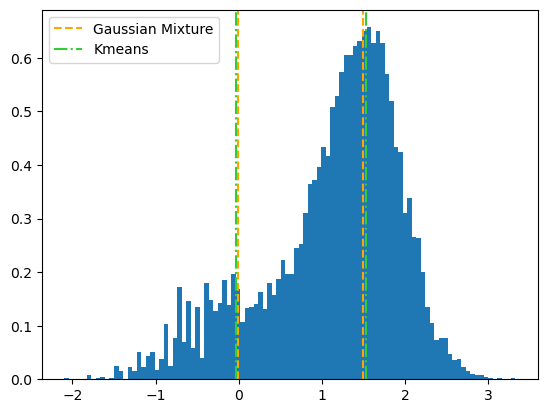

In [63]:
plt.hist(log10T90, density = True, bins = 100)
plt.axvline(gm.means_[0], linestyle = '--', color = 'orange', label = 'Gaussian Mixture')
plt.axvline(gm.means_[1], linestyle = '--', color = 'orange')
plt.axvline(clf.cluster_centers_[1], linestyle = '-.', color = 'limegreen', label = 'Kmeans')
plt.axvline(clf.cluster_centers_[0], linestyle = '-.', color = 'limegreen')
plt.legend();

In [83]:
prediction = gm.predict(log10T90[:, None])
prediction = np.where((prediction==0)|(prediction==1), prediction^1, prediction) #take into consideration the fact that centers are inverted
confusion_matrix(prediction,clf.predict(log10T90[:, None]))

array([[5465,  269],
       [   0, 1623]], dtype=int64)

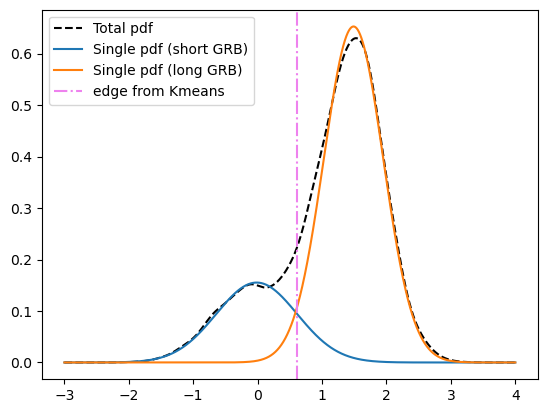

In [130]:
responsabilities = gm.predict_proba(xgrid[:, None])
single_pdfs = responsabilities*np.exp(gm.score_samples(xgrid[:, None]))[:, None]
edge = (np.mean( [max(log10T90[:, None][clf.predict(log10T90[:, None])==0]), min(log10T90[:, None][clf.predict(log10T90[:, None])==1]) ]))

plt.plot(xgrid, pdf, linestyle = '--', color = 'black', label = 'Total pdf')
plt.plot(xgrid, single_pdfs[:, 0], label = 'Single pdf (short GRB)')
plt.plot(xgrid, single_pdfs[:, 1], label = 'Single pdf (long GRB)')
plt.axvline(edge, color = 'violet', linestyle = '-.', label = 'edge from Kmeans')
plt.legend();

[]

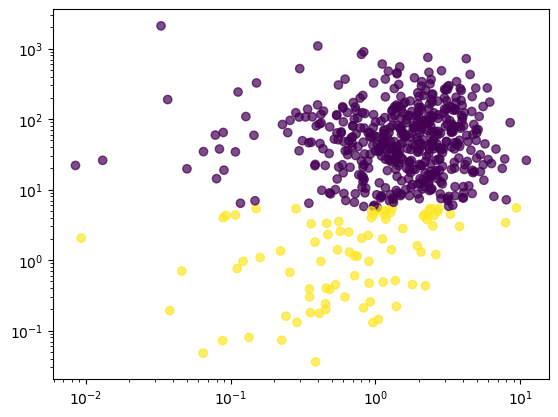

In [203]:
redshift = np.array(data[11],dtype=float)
T90= np.array(data[6],dtype=float)
condition = (T90 != -999) & (redshift != -999)
plt.scatter(redshift[condition], T90[condition], c = clf.predict(np.log10(T90[condition])[:, None]), alpha = 0.7)
plt.loglog()

In [204]:
clf_2 = KMeans(n_clusters = 2, n_init = 10)

X = np.column_stack([np.log10(redshift[condition]),np.log10(T90[condition])])
clf_2.fit(X)

KMeans(n_clusters=2, n_init=10)

In [205]:
clf_2.cluster_centers_

array([[ 0.19484228,  1.81165451],
       [-0.10254572,  0.44637417]])

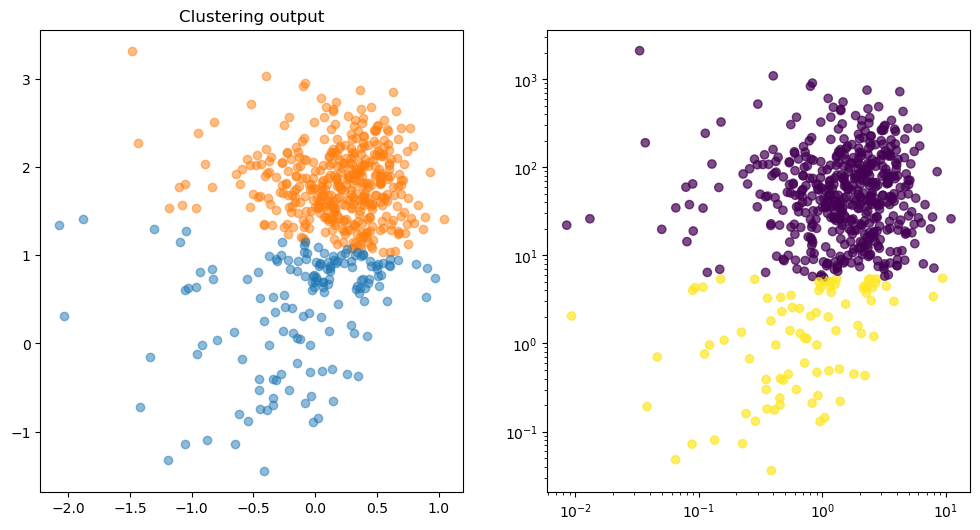

In [208]:
centers = clf_2.cluster_centers_ #location of the clusters
labels = clf_2.predict(X) #labels for each of the points

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
colors = ['C1', 'C0', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)
plt.title('Clustering output')
ax_2 = fig.add_subplot(1,2,2)
plt.scatter(redshift[condition],T90[condition], c = clf.predict(np.log10(T90[condition])[:, None]), alpha = 0.7)
plt.loglog();